<a href="https://colab.research.google.com/github/NatasaKinzy/Data-Science/blob/main/Unit4/NataKinzUnit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'

In [ ]:
cs_data = pd.read_csv(url_cs)

In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

In [ ]:
aa_idx = aa_encode.codes
aa_idx

In [ ]:
aa_coords = {"aa": aa_encode.categories}
aa_coords

In [ ]:
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu = 30, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu = 30, sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam = 1/30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ', nu = μ_nu,
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 30, sigma = 10, dims = "aa")

    v = pm.Exponential('v', lam = 1/30, dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y', nu = v[aa_idx],
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

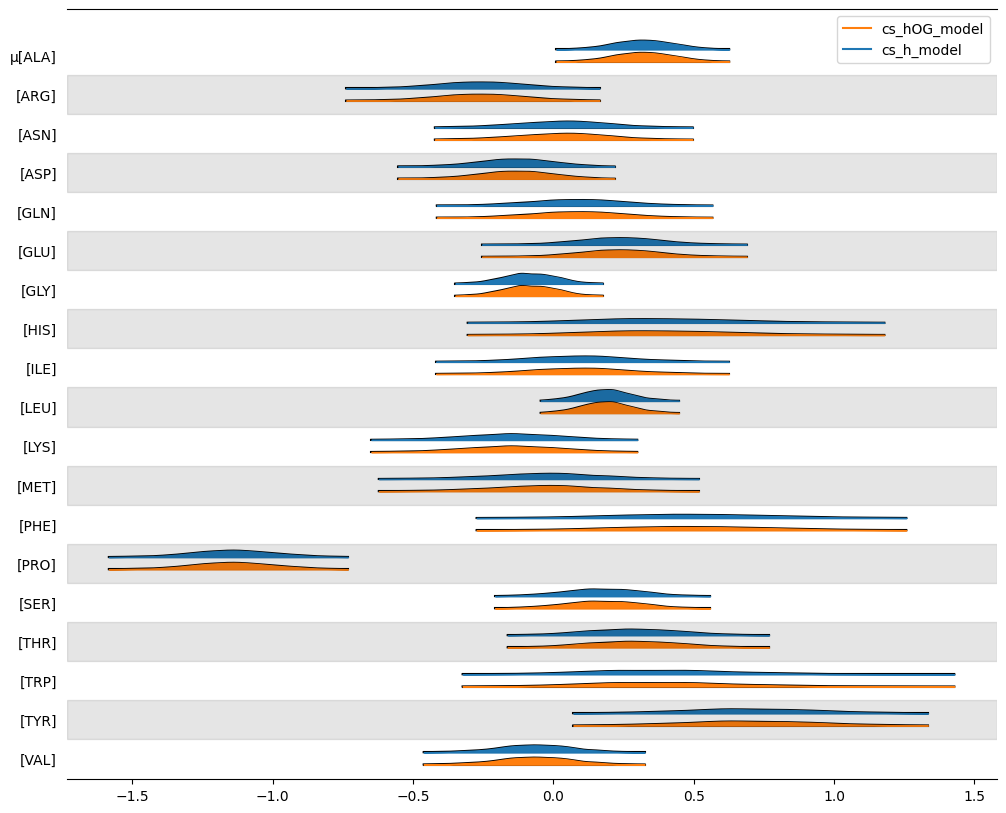

In [ ]:
axes = az.plot_forest([idata_cs_h, idata_cs_h], kind="ridgeplot",
                      model_names=['cs_h_model', 'cs_hOG_model'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

In [ ]:
with pm.Model(coords=aa_coords) as cs_hOG_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_hOG = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_cs_hOG, model=cs_hOG_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_hOG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Honestly, they both look pretty much the same to me. Their scales are different and both have a slight right skew. Although, the StudentT and HalfStudentT speaks to me more than the original because the distribution is very obviously extremely centered around 0 and it was a pain to make so I'm going to say it's better so my work feels more substantial.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [ ]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
  #remove hyperperameters to make independent.
  #use hyperparameters in "Parameters for positions"
  #In μ_p, mu = alpha/beta+alpha and nu = v from hyperparameters
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = (2/(2+20)), nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

In [ ]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.002 1.0 1.002 1.001 ... 0.9999 1.001 1.003
    μ_p      (pos) float64 32B 1.009 0.9998 1.037 1.001
    ν_p      (pos) float64 32B 1.07 1.002 1.057 1.009

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

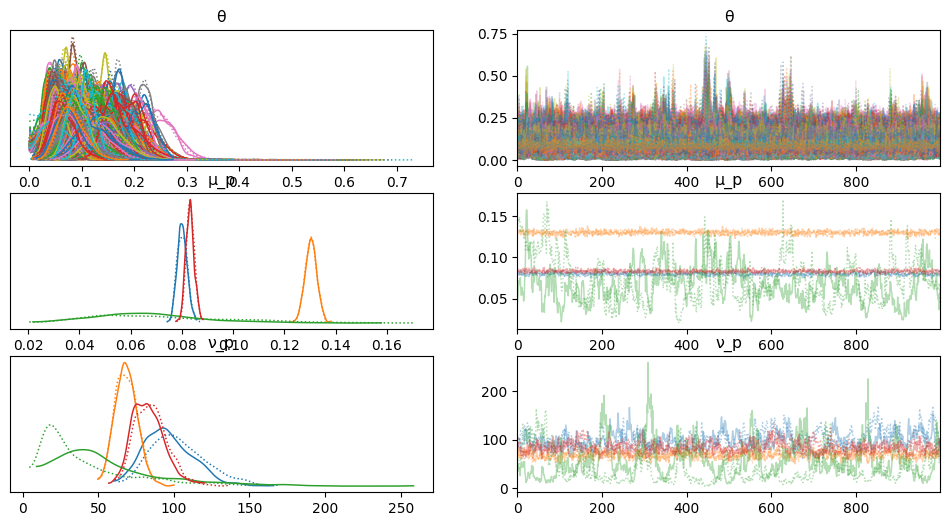

In [ ]:
az.plot_trace(idata_sccr)

1-1.001 is good, 1.1 is bad. The heirarchical model (the one that had the groups as dependent), had relatively good rhat values. Theta was equal to 0.9994-1.001. As for my new model, the rhat values arent as good as they have a range of 0.9998-1.057. They're definitely not bad, they're just not as good. Although, I also notice that the heirarchical model had some lower rhat values as compared to the non-heirarchical. I don't know what this means but that's what I noticed :) The graphs also look fairly similar but mine tend to be shifted lower on the y-axis.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

In [ ]:
with pm.Model(coords = sccr_coords) as sccrOG_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccrOG = pm.sample(target_accept = 0.95)

In [ ]:
az.plot_forest(idata_sccrOG, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
# Filter out goalkeepers
sccr_data_no_gk = sccr_data[sccr_data.position != 'GK'].copy()

# Reset categories after filtering
sccr_data_no_gk['position'] = sccr_data_no_gk['position'].cat.remove_unused_categories()

# Update pos_idx and sccr_coords with the filtered data
# Ensure pos_idx_no_gk reflects the new category codes
pos_idx_no_gk = sccr_data_no_gk.position.cat.codes.values
pos_codes_no_gk = sccr_data_no_gk.position.cat.categories.tolist()
sccr_coords_no_gk = {"pos": pos_codes_no_gk}

print("pos_idx_no_gk unique values:", np.unique(pos_idx_no_gk))
print("pos_codes_no_gk:", pos_codes_no_gk)

with pm.Model(coords = sccr_coords_no_gk) as sccr_model_no_gk:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)

    # Parameters for positions
    # Use dims="pos" to link to the coordinate
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")
    print("μ_p shape:", μ_p.shape)


    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_no_gk], nu = ν_p[pos_idx_no_gk])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_no_gk.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_no_gk.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_no_gk = pm.sample(target_accept = 0.95)

  #Used Gemini to generate code and asked for explinations along the way.

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

In [ ]:
#with GK

with pm.Model(coords = sccr_coords) as sccrOG_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccrOG = pm.sample(target_accept = 0.95)

In [ ]:
az.rhat(idata_sccrOG)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.002 1.005 1.002 ... 1.001 1.001 1.002
    μ        float64 8B 1.0
    μ_p      (pos) float64 32B 1.003 1.0 1.028 1.0
    ν        float64 8B 1.0
    ν_p      (pos) float64 32B 1.021 1.006 1.158 1.008

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

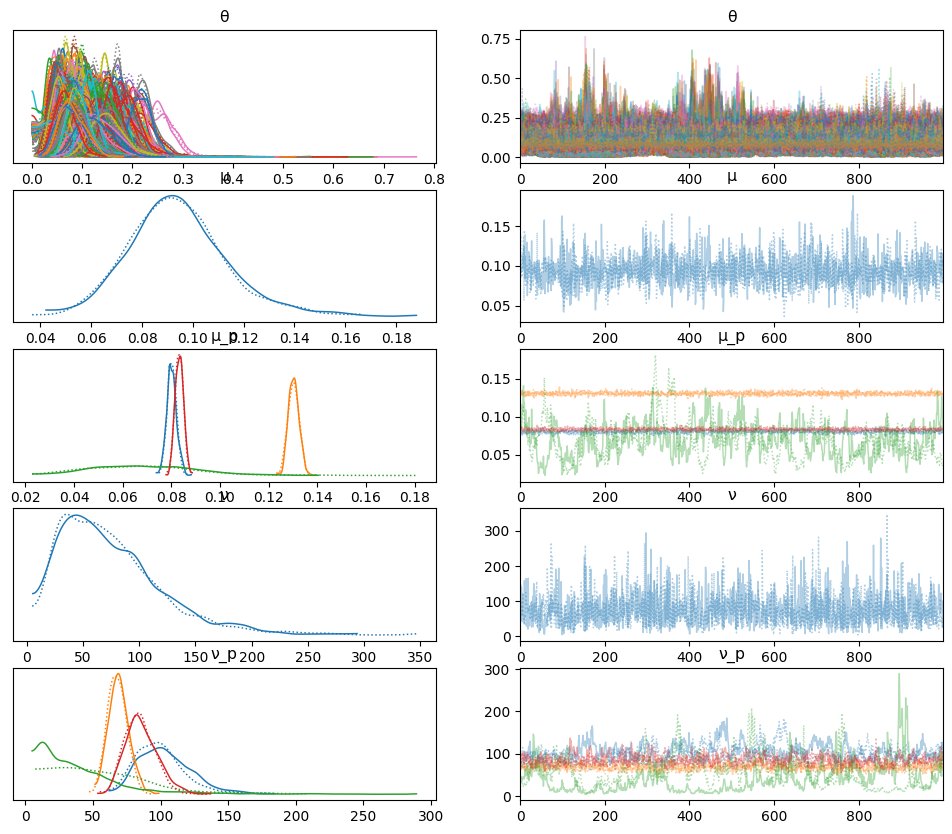

In [ ]:
az.plot_trace(idata_sccrOG)

In [ ]:
#without GK is just idata_sccr_no_gk
az.rhat(idata_sccr_no_gk)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.0 1.002 1.006 1.002 ... 0.9998 1.001 1.001
    μ        float64 8B 1.001
    μ_p      (pos) float64 24B 1.004 1.0 1.003
    ν        float64 8B 0.9997
    ν_p      (pos) float64 24B 1.021 1.002 1.009

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

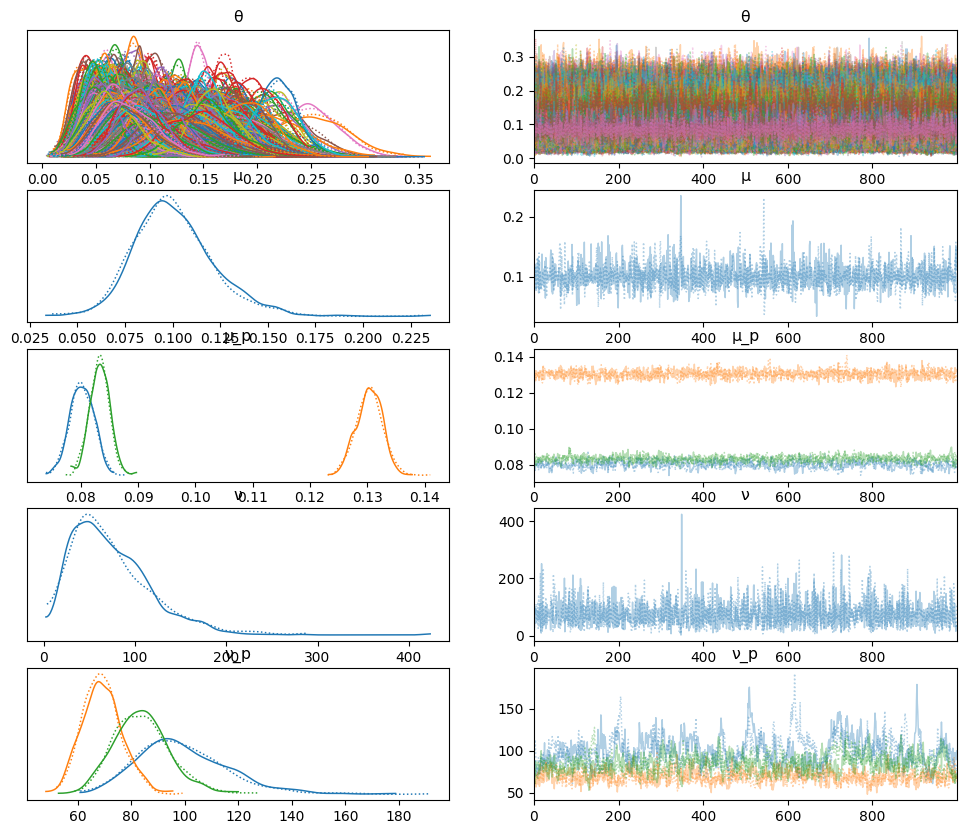

In [ ]:
az.plot_trace(idata_sccr_no_gk)

The heirarchical model without GK was easier for pymc to process.

When we no longer include GK in our data set we lose extra data points (a whole column of our data set). However, even though we lose some points, I think losing GK probably makes our models much more accurate overall as GKs don't usually shoot goals, so they are, in my opinion, outliers that skew our data set and we'll be better off without them.